In [1]:
import numpy as np
import pandas as pd
from matplotlib import colormaps
import matplotlib.colors as cls
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import matplotlib.image as img
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
%matplotlib inline
import seaborn as sns
import random
import networkx as nx

### Collecting edges from the data to bild a network

1. Data import

In [2]:
df_APS = pd.read_csv('.../final_table_20240110.csv', sep=';', encoding="ISO-8859-1")

2. Collecting the edges

In [3]:
# selection of only the disease data
diseaseOnly = df_APS.copy()
diseaseOnly = diseaseOnly.iloc[:, 6:34]

In [4]:
# to collect all disease combinations
dis_comb_list = []

for i in range(len(diseaseOnly.index)):
    dis_inst = diseaseOnly.iloc[i,:]   
    dis_combs = str(dis_inst[dis_inst == 1].index)
    dis_combs = dis_combs.replace("'", "")
    dis_combs = dis_combs[6:-15]
    dis_comb_list.append(dis_combs)

In [5]:
dis_comb_list[:10]

['[hashimoto, diabetes_mellitus_1]',
 '[hashimoto, crohn]',
 '[hashimoto, vitiligo]',
 '[hashimoto, diabetes_mellitus_1, vitiligo]',
 '[basedow, diabetes_mellitus_1]',
 '[diabetes_mellitus_1, coeliakia]',
 '[basedow, RA]',
 '[hashimoto, early_gonadal_insufficiency, sjögren]',
 '[hashimoto, primer_biliaris_cholangitis]',
 '[hashimoto, diabetes_mellitus_1, hepatitis]']

In [6]:
# to add the results to the df
df_APS['combinations'] = pd.Series(dis_comb_list)

In [12]:
# to separate the combinations of 2, 3 or 4 diseases
dis2 = df_APS.copy()
dis2 = dis2[dis2['assoc_disease_no'] == 2]

dis3 = df_APS.copy()
dis3 = dis3[dis3['assoc_disease_no'] == 3]

dis4 = df_APS.copy()
dis4 = dis4[dis4['assoc_disease_no'] == 4]

In [32]:
# edges for the combinations of 2 diseases
edges_dis2 = dis2[['combinations']]
edges_dis2.to_csv('edges_dis2.csv')   # to save as a .csv file

# edges for the combinations of 3 diseases
edges_dis3 = dis3.groupby('combinations').count()
edges_dis3 = edges_dis3[['assoc_disease_no']].sort_values('assoc_disease_no', ascending=False)
edges_dis3.rename(columns = {'assoc_disease_no':'count'}, inplace=True)

edges_dis3.to_csv('edges_dis3_count.csv')   # to save as a .csv file

# edges for the combinations of 4 diseases
edges_dis4 = dis4.groupby('combinations').count()
edges_dis4 = edges_dis4[['assoc_disease_no']].sort_values('assoc_disease_no', ascending=False)
edges_dis4.rename(columns = {'assoc_disease_no':'count'}, inplace=True)

edges_dis4.to_csv('edges_dis4_count.csv')   # to save as a .csv file

Individual edges were manually separated from the combinations of 3 or 4 diseases, from the edges_dis3_count.csv and edges_dis4_count.csv files. Following this step, these edges were imported to calculate the number and the frequency of their occurrence:

In [40]:
# importing all edges
allEdges = pd.read_csv('C:/Adatok/SzKK/Emese csoportja/Greti anyaga/corrected final data/network analysis/allEdges.csv', sep=';', encoding="ISO-8859-1")

# all edges
allEdges_count = allEdges.groupby('combination').count()
allEdges_count = allEdges_count.sort_values('index', ascending=False)
allEdges_count.rename(columns = {'index':'count'}, inplace=True)

allEdges_count.sort_values('combination').to_csv('allEdges_count.csv')   # to save all edges as a .csv file

In [44]:
allEdges_count.head(10)

,count
combination,
"hashimoto, diabetes_mellitus_1",50
"hashimoto, coeliakia",47
"hashimoto, vitiligo",29
"adrenal, hashimoto",28
"hashimoto, autoimmun_gastritis",25
"hashimoto, RA",24
"hashimoto, sjögren",22
"basedow, coeliakia",20
"basedow, RA",19


### Finding the most frequent disease combinations in the cohort

In [7]:
# to count the number of the combinations
combination_freq = df_APS.groupby('combinations', as_index=False).count()[['combinations', 'assoc_disease_no']]
combination_freq = combination_freq.sort_values('assoc_disease_no', ascending=False)
combination_freq = combination_freq.reset_index(drop=True)
combination_freq.rename(columns = {'assoc_disease_no':'count'}, inplace=True)

# to calculate the frequency of the combinations
combination_freq['percentage'] = combination_freq['count'] / combination_freq['count'].sum() * 100

In [8]:
combination_freq.head(10)

,combinations,count,percentage
0,"[hashimoto, diabetes_mellitus_1]",36,9.473684
1,"[hashimoto, coeliakia]",29,7.631579
2,"[hashimoto, RA]",22,5.789474
3,"[adrenal, hashimoto]",18,4.736842
4,"[hashimoto, vitiligo]",18,4.736842
5,"[basedow, RA]",15,3.947368
6,"[basedow, coeliakia]",13,3.421053
7,"[basedow, diabetes_mellitus_1]",12,3.157895
8,"[hashimoto, autoimmun_gastritis]",11,2.894737
9,"[hashimoto, SLE]",11,2.894737


In [9]:
# proportions, relative to the entire cohort
indiv = combination_freq[combination_freq['count'] == 1]['count'].sum() / combination_freq['count'].sum() * 100
above1 = combination_freq[combination_freq['count'] > 1]['count'].sum() / combination_freq['count'].sum() * 100
above5 = combination_freq[combination_freq['count'] >= 5]['count'].sum() / combination_freq['count'].sum() * 100
above10 = combination_freq[combination_freq['count'] >= 10]['count'].sum() / combination_freq['count'].sum() * 100

print(f"Percentage of individual combinations: {indiv}")
print(f"Percentage of combinations that appear more than ones: {above1}")
print(f"Percentage of combinations that appear 5 or more times: {above5}")
print(f"Percentage of combinations that appear 10 or more times: {above10}")

Percentage of individual combinations: 17.63157894736842
Percentage of combinations that appear more than ones: 82.36842105263158
Percentage of combinations that appear 5 or more times: 63.94736842105263
Percentage of combinations that appear 10 or more times: 51.31578947368421


### Network construction

In [10]:
# list of weighted edges
weightedEdges = [('adrenal', 'RA', 3),
('adrenal', 'SLE', 1),
('adrenal', 'autoimmun_gastritis', 6),
('adrenal', 'basedow', 9),
('adrenal', 'crohn', 1),
('adrenal', 'diabetes_mellitus_1', 3),
('adrenal', 'early_gonadal_insufficiency', 2),
('adrenal', 'hashimoto', 28),
('adrenal', 'sclerosis_multiplex', 1),
('adrenal', 'sjögren', 1),
('adrenal', 'vitiligo', 4),
('autoimmun_gastritis', 'RA', 1),
('autoimmun_gastritis', 'SLE', 1),
('autoimmun_gastritis', 'coeliakia', 7),
('autoimmun_gastritis', 'colitis_ulcerosa', 1),
('autoimmun_gastritis', 'crohn', 2),
('autoimmun_gastritis', 'diabetes_mellitus_1', 4),
('autoimmun_gastritis', 'early_gonadal_insufficiency', 1),
('autoimmun_gastritis', 'haemolyticus_anaemia', 1),
('autoimmun_gastritis', 'hypopara', 1),
('autoimmun_gastritis', 'primer_antiphospholipid', 1),
('autoimmun_gastritis', 'psoriasis', 1),
('autoimmun_gastritis', 'sclerosis_multiplex', 1),
('autoimmun_gastritis', 'sjögren', 2),
('autoimmun_gastritis', 'vitiligo', 4),
('basedow', 'ITP', 1),
('basedow', 'RA', 19),
('basedow', 'SLE', 5),
('basedow', 'autoimmun_gastritis', 12),
('basedow', 'coeliakia', 20),
('basedow', 'colitis_ulcerosa', 5),
('basedow', 'crohn', 7),
('basedow', 'diabetes_mellitus_1', 18),
('basedow', 'myasthenia_gravis', 5),
('basedow', 'polymyositis', 1),
('basedow', 'primer_biliaris_cholangitis', 3),
('basedow', 'psoriasis', 4),
('basedow', 'sclerosis_multiplex', 3),
('basedow', 'sjögren', 3),
('basedow', 'systemic_sclerosis', 1),
('basedow', 'vitiligo', 9),
('coeliakia', 'SLE', 2),
('coeliakia', 'primer_antiphospholipid', 1),
('coeliakia', 'psoriasis', 4),
('coeliakia', 'sclerosis_multiplex', 1),
('coeliakia', 'sjögren', 5),
('colitis_ulcerosa', 'SLE', 2),
('colitis_ulcerosa', 'coeliakia', 2),
('colitis_ulcerosa', 'psoriasis', 1),
('colitis_ulcerosa', 'sclerosing_cholangitis', 1),
('colitis_ulcerosa', 'sclerosis_multiplex', 1),
('colitis_ulcerosa', 'sjögren', 1),
('crohn', 'psoriasis', 1),
('diabetes_mellitus_1', 'RA', 2),
('diabetes_mellitus_1', 'alopecia', 1),
('diabetes_mellitus_1', 'coeliakia', 13),
('diabetes_mellitus_1', 'colitis_ulcerosa', 2),
('diabetes_mellitus_1', 'early_gonadal_insufficiency', 1),
('diabetes_mellitus_1', 'hepatitis', 3),
('diabetes_mellitus_1', 'psoriasis', 2),
('diabetes_mellitus_1', 'sclerosing_cholangitis', 1),
('diabetes_mellitus_1', 'sjögren', 1),
('diabetes_mellitus_1', 'vitiligo', 2),
('early_gonadal_insufficiency', 'alopecia', 1),
('early_gonadal_insufficiency', 'colitis_ulcerosa', 1),
('early_gonadal_insufficiency', 'crohn', 1),
('early_gonadal_insufficiency', 'psoriasis', 2),
('early_gonadal_insufficiency', 'sjögren', 1),
('haemolyticus_anaemia', 'hepatitis', 1),
('hashimoto', 'RA', 24),
('hashimoto', 'SLE', 15),
('hashimoto', 'alopecia', 10),
('hashimoto', 'autoimmun_gastritis', 25),
('hashimoto', 'coeliakia', 47),
('hashimoto', 'colitis_ulcerosa', 10),
('hashimoto', 'crohn', 5),
('hashimoto', 'diabetes_mellitus_1', 50),
('hashimoto', 'early_gonadal_insufficiency', 12),
('hashimoto', 'haemolyticus_anaemia', 3),
('hashimoto', 'hepatitis', 7),
('hashimoto', 'hypophysitis', 1),
('hashimoto', 'myasthenia_gravis', 3),
('hashimoto', 'polymyositis', 5),
('hashimoto', 'primer_antiphospholipid', 2),
('hashimoto', 'primer_biliaris_cholangitis', 5),
('hashimoto', 'psoriasis', 12),
('hashimoto', 'sclerosis_multiplex', 2),
('hashimoto', 'sjögren', 22),
('hashimoto', 'systemic_sclerosis', 3),
('hashimoto', 'vitiligo', 29),
('hepatitis', 'RA', 1),
('hepatitis', 'SLE', 1),
('hepatitis', 'coeliakia', 1),
('hepatitis', 'sclerosing_cholangitis', 1),
('hepatitis', 'sjögren', 1),
('hypopara', 'colitis_ulcerosa', 1),
('hypopara', 'hypophysitis', 1),
('hypopara', 'mucocutan_candidiasis', 1),
('hypopara', 'sclerosing_cholangitis', 1),
('hypophysitis', 'colitis_ulcerosa', 1),
('hypophysitis', 'sclerosing_cholangitis', 1),
('primer_biliaris_cholangitis', 'coeliakia', 2),
('primer_biliaris_cholangitis', 'sjögren', 3),
('psoriasis', 'primer_antiphospholipid', 1),
('sjögren', 'RA', 2),
('sjögren', 'alopecia', 1),
('sjögren', 'psoriasis', 1),
('SLE', 'myasthenia_gravis', 2),
('vitiligo', 'alopecia', 1),
('vitiligo', 'coeliakia', 1),
('vitiligo', 'early_gonadal_insufficiency', 1),
('vitiligo', 'myasthenia_gravis', 1),
('vitiligo', 'polymyositis', 1),
('vitiligo', 'psoriasis', 1),
('vitiligo', 'sjögren', 1)]

In [11]:
# to create a graph
G = nx.Graph()
G.add_weighted_edges_from(weightedEdges)

Basic information about the graph

In [12]:
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

Number of nodes: 28
Number of edges: 115


In [13]:
# to list nodes with their degree
list(G.degree)

[('adrenal', 11),
 ('RA', 7),
 ('SLE', 8),
 ('autoimmun_gastritis', 17),
 ('basedow', 17),
 ('crohn', 6),
 ('diabetes_mellitus_1', 14),
 ('early_gonadal_insufficiency', 10),
 ('hashimoto', 22),
 ('sclerosis_multiplex', 6),
 ('sjögren', 14),
 ('vitiligo', 12),
 ('coeliakia', 13),
 ('colitis_ulcerosa', 13),
 ('haemolyticus_anaemia', 3),
 ('hypopara', 5),
 ('primer_antiphospholipid', 4),
 ('psoriasis', 11),
 ('ITP', 1),
 ('myasthenia_gravis', 4),
 ('polymyositis', 3),
 ('primer_biliaris_cholangitis', 4),
 ('systemic_sclerosis', 2),
 ('sclerosing_cholangitis', 5),
 ('alopecia', 5),
 ('hepatitis', 8),
 ('hypophysitis', 4),
 ('mucocutan_candidiasis', 1)]

### Community detection

In [14]:
# community detection with the Louvain method
communities = nx.community.louvain_communities(G, weight='weight', resolution=1.1)

In [15]:
# three communities were found
Community_1 = list(communities[0])
Community_2 = list(communities[1])
Community_3 = list(communities[2])

print(f'Community 1: {Community_1}')
print('')
print('')
print(f'Community 2: {Community_2}')
print('')
print('')
print(f'Community 3: {Community_3}')

Community 1: ['RA', 'ITP', 'crohn', 'sclerosis_multiplex', 'adrenal', 'basedow', 'myasthenia_gravis', 'autoimmun_gastritis']


Community 2: ['polymyositis', 'vitiligo', 'systemic_sclerosis', 'primer_antiphospholipid', 'coeliakia', 'alopecia', 'hashimoto', 'early_gonadal_insufficiency', 'sjögren', 'diabetes_mellitus_1', 'hepatitis', 'haemolyticus_anaemia', 'psoriasis', 'primer_biliaris_cholangitis']


Community 3: ['hypopara', 'sclerosing_cholangitis', 'SLE', 'colitis_ulcerosa', 'hypophysitis', 'mucocutan_candidiasis']


<br>

Resolution values were tested from 0.5 to 1.6: resolution=1.1 provided relatively stable, reproducible communities although SLE was switching between two communities. SLE was either within its current cluster (Community 3) or in Community 1. 

### Visualization

1. Bar chart

In [16]:
# selecting only those combinations that appear more than ones for visualisation
mFreq_forPlot = combination_freq.copy()
mFreq_forPlot = mFreq_forPlot[mFreq_forPlot['count'] > 1]

In [20]:
# the content of the 'combinations' column needs to be modified for better visualisation
# dictionary, to replace specific characters
char_replace = {',':' +', '\[':'', '\]':''}

# dictionary, to replace disease names with their abbreviations
disease_rep = {'adrenal':'AD',  
               'autoimmun_gastritis':'AIG', 
               'basedow':'GD', 
               'crohn':'CD', 
               'diabetes_mellitus_1':'T1D', 
               'early_gonadal_insufficiency':'POF', 
               'hashimoto':'HT', 
               'sclerosis_multiplex':'MS', 
               'sjögren':'SS', 
               'vitiligo':'Vit', 
               'coeliakia':'CeD', 
               'colitis_ulcerosa':'UC', 
               'haemolyticus_anaemia':'AIHA', 
               'hypopara':'hypoPT', 
               'primer_antiphospholipid':'PAPS', 
               'psoriasis':'PsO', 
               'ITP':'ITP', 
               'myasthenia_gravis':'MG', 
               'polymyositis':'PM', 
               'primer_biliaris_cholangitis':'PBC', 
               'systemic_sclerosis':'SSc', 
               'sclerosing_cholangitis':'PSC', 
               'alopecia':'Alo', 
               'hepatitis':'AIH', 
               'hypophysitis':'LH', 
               'mucocutan_candidiasis':'CMC'}

# replacing values in the 'combinations' column 
mFreq_forPlot.replace({'combinations':char_replace}, regex=True, inplace=True)
mFreq_forPlot.replace({'combinations':disease_rep}, regex=True, inplace=True)

In [22]:
# creating a new column for coloring the bar chart
color_list = []

for col in range(len(mFreq_forPlot.index)):
    if mFreq_forPlot['count'][col] >= 10:
        color_list.append(0)
    elif mFreq_forPlot['count'][col] >= 5 and mFreq_forPlot['count'][col] < 10:
        color_list.append(1)
    else:
        color_list.append(2)

mFreq_forPlot['color'] = pd.Series(color_list)

# color map for coloring the bar chart
barPlot_cmap = ['#ec2e2e', '#eca72e', '#7d7d7d']

2. Network plots

    2.A. For general visualisation

In [27]:
# to use degree as the size of a node
node_size = [G.degree(v)*15 for v in G]

In [24]:
# dictionary of labels for visualisation
label_dict = {}
label_dict['adrenal'] = 'AD'
label_dict['RA'] ='RA'
label_dict['SLE'] = 'SLE'
label_dict['autoimmun_gastritis'] = 'AIG'
label_dict['basedow'] = 'GD'
label_dict['crohn'] = 'CD'
label_dict['diabetes_mellitus_1'] = 'T1D'
label_dict['early_gonadal_insufficiency'] = 'POF'
label_dict['hashimoto'] = 'HT'
label_dict['sclerosis_multiplex'] = 'MS'
label_dict['sjögren'] = 'SS'
label_dict['vitiligo'] = 'Vit'
label_dict['coeliakia'] = 'CeD'
label_dict['colitis_ulcerosa'] = 'UC'
label_dict['haemolyticus_anaemia'] = 'AIHA'
label_dict['hypopara'] = 'hypoPT'
label_dict['primer_antiphospholipid'] = 'PAPS'
label_dict['psoriasis'] = 'PsO'
label_dict['ITP'] = 'ITP'
label_dict['myasthenia_gravis'] = 'MG'
label_dict['polymyositis'] = 'PM'
label_dict['primer_biliaris_cholangitis'] = 'PBC'
label_dict['systemic_sclerosis'] = 'SSc'
label_dict['sclerosing_cholangitis'] = 'PSC'
label_dict['alopecia'] = 'Alo'
label_dict['hepatitis'] = 'AIH'
label_dict['hypophysitis'] = 'LH'
label_dict['mucocutan_candidiasis'] = 'CMC'

In [25]:
# color map for coloring nodes based on the Louvain communities (for the spring and circular layouts)
cmap = []

for node in G:
    if node in Community_3:
        cmap.append('#7570B3')
    elif node in Community_1:
        cmap.append('#E7298A')
    else:
        cmap.append('#1B9E77')

    2.B. For the circular layout

In [28]:
# color map for edge coloring
usedCmap = colormaps.get_cmap('Oranges')
circular_cmap = cls.ListedColormap(usedCmap(np.linspace(0.10, 1, 49)))

In [29]:
# to assign edge color with weight
colors = nx.get_edge_attributes(G, 'weight').values()

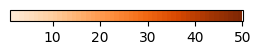

In [30]:
# legend for edge coloring
norm = cls.Normalize(vmin=1, vmax=50)

fig, ax = plt.subplots(figsize=(3, 0.3))
fig.subplots_adjust(bottom=0.5)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=circular_cmap), cax=ax, orientation='horizontal')

#fig.savefig('APSnetwork_circular_colorbar.tiff', bbox_inches='tight', dpi=300)

<br>

    2.C. For the Kamada-Kawai layout

With this layout, nodes and egdes are manually colored based on whether they are associated to HT, GD, both or none.

In [31]:
# diseases that associated to HT
HT_adj = list(G.adj['hashimoto'])

# diseases that associated to GD
GD_adj = list(G.adj['basedow'])

# diseases that associated to both HT and GD
HT_GD_common = []

for disease in HT_adj:
    if disease in GD_adj:
        HT_GD_common.append(disease)

In [32]:
HT_GD_common

['adrenal',
 'RA',
 'SLE',
 'autoimmun_gastritis',
 'coeliakia',
 'colitis_ulcerosa',
 'crohn',
 'diabetes_mellitus_1',
 'myasthenia_gravis',
 'polymyositis',
 'primer_biliaris_cholangitis',
 'psoriasis',
 'sclerosis_multiplex',
 'sjögren',
 'systemic_sclerosis',
 'vitiligo']

In [33]:
# only HT associated diseases
only_HT_adj = []

for disease in HT_adj:
    if disease in HT_GD_common:
        print(f'common disease: {disease}')   # to chechk if it was correct
    else:
        only_HT_adj.append(disease)

common disease: adrenal
common disease: RA
common disease: SLE
common disease: autoimmun_gastritis
common disease: coeliakia
common disease: colitis_ulcerosa
common disease: crohn
common disease: diabetes_mellitus_1
common disease: myasthenia_gravis
common disease: polymyositis
common disease: primer_biliaris_cholangitis
common disease: psoriasis
common disease: sclerosis_multiplex
common disease: sjögren
common disease: systemic_sclerosis
common disease: vitiligo


In [34]:
only_HT_adj

['alopecia',
 'early_gonadal_insufficiency',
 'haemolyticus_anaemia',
 'hepatitis',
 'hypophysitis',
 'primer_antiphospholipid']

In [35]:
# only GD associated diseases
only_GD_adj = []

for disease in GD_adj:
    if disease in HT_GD_common:
        print(f'common disease: {disease}')   # to chechk if it was correct
    else:
        only_GD_adj.append(disease)

common disease: adrenal
common disease: RA
common disease: SLE
common disease: autoimmun_gastritis
common disease: coeliakia
common disease: colitis_ulcerosa
common disease: crohn
common disease: diabetes_mellitus_1
common disease: myasthenia_gravis
common disease: polymyositis
common disease: primer_biliaris_cholangitis
common disease: psoriasis
common disease: sclerosis_multiplex
common disease: sjögren
common disease: systemic_sclerosis
common disease: vitiligo


In [36]:
only_GD_adj

['ITP']

In [37]:
# color map for node coloring
kamkaw_node_cmap = []

for node in G:
    if node in only_HT_adj or node == 'hashimoto':
        kamkaw_node_cmap.append('orange')
    elif node in only_GD_adj or node == 'basedow':
        kamkaw_node_cmap.append('#34b8ed')
    elif node in HT_GD_common:
        kamkaw_node_cmap.append('#e6000a')
    else:
        kamkaw_node_cmap.append('#939393')

In [38]:
# color map for edge coloring
kamkaw_edge_cmap = []

for edge in list(G.edges):
    if 'hashimoto' in  edge:
        kamkaw_edge_cmap.append('#ffc263')
    elif 'basedow' in edge:
        kamkaw_edge_cmap.append('#73ccf0')
    else:
        kamkaw_edge_cmap.append('#bababa')

3. The actual figure

In [39]:
# composing custom legends
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster 1',
                          markerfacecolor='#1B9E77', markersize=6), 
                   Line2D([0], [0], marker='o', color='w', label='Cluster 2',
                          markerfacecolor='#E7298A', markersize=6), 
                   Line2D([0], [0], marker='o', color='w', label='Cluster 3',
                          markerfacecolor='#7570B3', markersize=6),]

legend_elements2 = [Line2D([0], [0], marker='o', color='w', label='HT associated diseases',
                          markerfacecolor='orange', markersize=6), 
                    Line2D([0], [0], marker='o', color='w', label='GD associated diseases',
                          markerfacecolor='#34b8ed', markersize=6), 
                    Line2D([0], [0], marker='o', color='w', label='Associated to both HT and GD',
                          markerfacecolor='#e6000a', markersize=6), 
                    Line2D([0], [0], marker='o', color='w', label='Not associated to HT or GD',
                          markerfacecolor='#939393', markersize=6),]

In [40]:
# to import colorbar as an image for the circular network plot
cBar = img.imread('APSnetwork_circular_colorbar.tiff')

Text(0.46, 0.48, 'D')

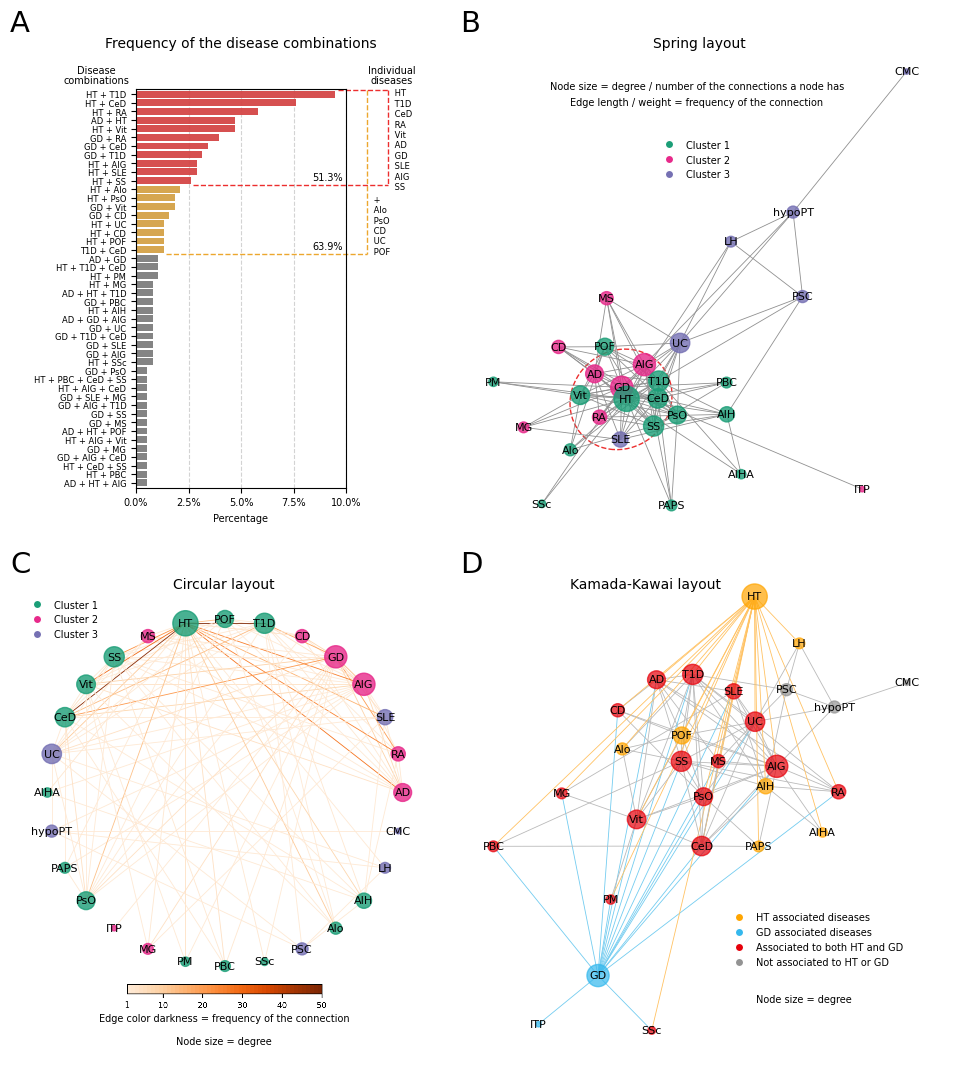

In [49]:
# to set random seed for network visualisation
random.seed(1004)
np.random.seed(1004)

# to set text sizes for the figure
plt.rc('axes', labelsize=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=6)

# figure
fig = plt.figure(figsize=(10,10.5))
ax1 = fig.add_axes([0.136,0.56,0.21,0.38])
ax2 = fig.add_axes([0.45,0.5,0.5,0.5])
ax3 = fig.add_axes([0.01,0.07,0.43,0.40])
ax4 = fig.add_axes([0.45,0,0.5,0.5])

# A
sns.barplot(data=mFreq_forPlot, x='percentage', y='combinations', hue='color', 
            palette=barPlot_cmap, alpha=0.95, legend=False, ax=ax1)
ax1.set_xlim(0,10)
ax1.set_ylim(45.6, -0.6)
ax1.set_xticks(ticks=[0, 2.5, 5, 7.5, 10], labels=['0.0%', '2.5%', '5.0%', '7.5%', '10.0%'])
ax1.set_axisbelow(True)
ax1.grid(color = 'lightgrey', linestyle = '--', axis='x')
ax1.set_xlabel('Percentage')
ax1.set_ylabel('')
ax1.text(8.4, 10, '51.3%', fontsize=7)
ax1.text(8.4, 18, '63.9%', fontsize=7)
ax1.text(12.2, 11, ' HT \n T1D \n CeD \n RA \n Vit \n AD \n GD \n SLE \n AIG \n SS', fontsize=6)
ax1.text(11.2, 18.5, ' + \n Alo \n PsO \n CD \n UC \n POF', fontsize=6)
ax1.hlines(y=18.5, xmin=1.45, xmax=11, color='#eca72e', lw=1, ls='--', clip_on=False)
ax1.vlines(x=11, ymin=-0.5, ymax=18.5, color='#eca72e', lw=1, ls='--', clip_on=False)
ax1.hlines(y=-0.5, xmin=9.6, xmax=12, color='#ec2e2e', lw=1, ls='--', clip_on=False)
ax1.hlines(y=10.5, xmin=2.7, xmax=12, color='#ec2e2e', lw=1, ls='--', clip_on=False)
ax1.vlines(x=12, ymin=-0.5, ymax=10.5, color='#ec2e2e', lw=1, ls='--', clip_on=False)

# B
ellipse = Ellipse(xy=(-0.1, -0.07), width=0.26, height=0.33, angle=-10, 
                  edgecolor='#ec2e2e', fc='None', lw=1, ls='--')
ax2.add_patch(ellipse)

pos1 = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos1, node_size=node_size, node_color=cmap, alpha=0.8, ax=ax2)
nx.draw_networkx_edges(G, pos=pos1, edge_color='#909090', width=0.6, ax=ax2)
nx.draw_networkx_labels(G, pos=pos1, labels=label_dict, font_size=8, ax=ax2)
ax2.legend(handles=legend_elements, fontsize=7, frameon=False, loc=[0.41, 0.7])
ax2.axis('off')

# C
pos2=nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos=pos2, node_size=node_size, node_color=cmap, alpha=0.8, ax=ax3)
nx.draw_networkx_edges(G, pos=pos2, edge_color=colors, edge_cmap=circular_cmap, width=0.6, ax=ax3)
nx.draw_networkx_labels(G, pos=pos2, labels=label_dict, font_size=8, ax=ax3)
ax3.legend(handles=legend_elements, fontsize=7, frameon=False, loc=[0.03, 0.855])
ax3.axis('off')

imagebox = OffsetImage(cBar, zoom=0.2)
cBar_ab = AnnotationBbox(imagebox, (0.01,-1.18), frameon = False)
ax3.add_artist(cBar_ab)
ax3.text(-0.57, -1.24, '1', fontsize=5.41)

# D
pos3=nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos=pos3, node_size=node_size, node_color=kamkaw_node_cmap, alpha=0.7, ax=ax4)
nx.draw_networkx_edges(G, pos=pos3, edge_color=kamkaw_edge_cmap, width=0.6, ax=ax4)
nx.draw_networkx_labels(G, pos=pos3, labels=label_dict, font_size=8, ax=ax4)
ax4.legend(handles=legend_elements2, fontsize=7, frameon=False, loc=[0.55, 0.2])
ax4.axis('off')

# text for the figure
fig.text(0.105, 0.98, 'Frequency of the disease combinations', fontsize=10)
fig.text(0.077, 0.955, 'Disease', fontsize=7)
fig.text(0.063, 0.945, 'combinations', fontsize=7)
fig.text(0.3679, 0.955, 'Individual', fontsize=7)
fig.text(0.3705, 0.945, 'diseases', fontsize=7)
fig.text(0.653, 0.98, 'Spring layout', fontsize=10)
fig.text(0.55, 0.94, 'Node size = degree / number of the connections a node has', fontsize=7)
fig.text(0.57, 0.925, 'Edge length / weight = frequency of the connection', fontsize=7)
fig.text(0.173, 0.465, 'Circular layout', fontsize=10)
fig.text(0.099, 0.052, 'Edge color darkness = frequency of the connection', fontsize=7)
fig.text(0.176, 0.03, 'Node size = degree', fontsize=7)
fig.text(0.57, 0.465, 'Kamada-Kawai layout', fontsize=10)
fig.text(0.756, 0.07, 'Node size = degree', fontsize=7)

# lettering for the figure
fig.text(0.01, 0.995, 'A', fontsize=21)
fig.text(0.46, 0.995, 'B', fontsize=21)
fig.text(0.01, 0.48, 'C', fontsize=21)
fig.text(0.46, 0.48, 'D', fontsize=21)

#fig.savefig('network_APS.tiff', bbox_inches='tight', dpi=300)